In [2]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime 
from pandas_datareader import data as pdr
import pandas_ta as ta
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# data = dataframe in pandas format to calculate sma
# sma_value = is an array to calcuate the lenth of sma 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
import yfinance as yf
def sma(data,sma_value,variable):
     # auto assign a variable name based on length of sma 
    variable_name = 'SMA'+ str(sma_value)
    # calculate sma 
    data[variable_name] =ta.sma(data[variable], length=sma_value)
    # return sma variable calculated 
    return data[variable_name]
# sym =  string format, ticker name
# ema value = is an array to calcuate the lenth of ema 
# sma_value = is an array to calcuate the lenth of sma 
# close = variable use for calcuate sma and ema, either "Close"or "Adj Close" in string format
def getdata(sym,sma_value,ema_value,close):
    yf.pdr_override()
    today = datetime.datetime.now()
    df = pdr.get_data_yahoo(sym, start=datetime.datetime(today.year-5,today.month, 1),
                                    end=datetime.datetime(today.year, today.month, today.day)).reset_index()
    df['ticker'] =sym
        
    for i in sma_value:
        variable_name = 'SMA'+ str(i)
        df[variable_name] = sma(df,i,close)
    
    for i in ema_value:
        variable_name = 'EMA'+ str(i)
        df[variable_name] = ema(df,i,close)
        
    df['Bearish_engulfing'] = np.nan
    df['Bearish swing'] = np.nan
    df['Bearish pinbar'] = np.nan
    for i in range(2,df.shape[0]):
        current = df.iloc[i,:]
        prev = df.iloc[i-1,:]
        prev_2 = df.iloc[i-2,:]
        realbody = abs(current['Open'] - current['Close'])
        candle_range = current['High'] - current['Low']
        idx = df.index[i]
        df.loc[idx,'Bearish_engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']
        df.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
        df.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']        
    return df
# data = dataframe in pandas format to calculate ema
# ema_value = is an array to calcuate the lenth of ema 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def ema(data,ema_value,variable):
    # auto assign a variable name based on length of ema 
    variable_name = 'EMA'+ str(ema_value)
    # calculate ema 
    data[variable_name] = data[variable].ewm(span=ema_value, adjust=False).mean()
     # return ema variable calculated 
    return data[variable_name]

In [4]:
def bollinger_bands_strategy(source, length, mult):
    basis = source.rolling(length).mean()
    dev = mult * source.rolling(length).std()
    upper = basis + dev
    lower = basis - dev
    buy_entry = np.where((source > lower) & (source.shift(1) <= lower.shift(1)), 1, 0)
    sell_entry = np.where((source < upper) & (source.shift(1) >= upper.shift(1)), -1, 0)
    entry_signal = buy_entry + sell_entry
    #entry_signal[entry_signal == 0] = np.nan
    return pd.DataFrame({'source': source, 'basis': basis, 'upper': upper, 'lower': lower, 'entry_signal': entry_signal})

In [5]:
# data = dataframe with price,sma and ema value
# sma_selected = SMA period used to trigger signal
# ema_selected = EMA period used to trigger signal
def Generate_signal(data):    
    #table start
    df_init =  data.copy()
    
    
    df_init.loc[(df_init['Close']>=df_init['SMA60']), 'signal']=1
    df_init.loc[(df_init['Bearish_engulfing']==True) & (df_init['Close']<df_init['SMA60']), 'signal']=-1
    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['signal'] = df_init['signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.Date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.Date == i,'signal'] = 0 
        else:
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[df_init.Date == prev,'signal'].values[0]==-1):
                df_init.loc[df_init.Date == i,'signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[df_init.Date == prev,'signal'].values[0]==1):
                df_init.loc[df_init.Date == i,'signal'] = 2
              
            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==2)&(df_init.loc[df_init.Date == i,'signal'].values[0]!=-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 2
                
            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==0)&(df_init.loc[df_init.Date == i,'signal'].values[0]==-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init

In [6]:
# data = dataframe with signal to trigger
# capital = assume starting capital
# result data = to store win chance, average lost and other statistic data
from statistics import mean
def backtest_strategy(data,capital, result_data):   
    
    #table start
    df_init =  data.copy()
    df_init.set_index('Date',inplace=True) 
    
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=data.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)
    
    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)
    
    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    
    # obtain list of calendar 
    calendar = pd.Series(df_init.index.sort_values().unique()).iloc[1:]
    
    ''' assign a variable which is trade, earn trade and lost trade to calculate total number of trade, total earn trade 
    and total lost trade'''
    trade = 0
    earn_trade = 0
    loss_trade = 0
    
    ''' create an array to keep all earn value and lost value for each trade'''
    earn_value =[]
    lost_value =[]

    for date in calendar:
        
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        
        # calculate total stock value of yesterday 
        stock_holding = df_init.loc[(df_init.index==prev_date), 'units'].values[0]*df_init.loc[(df_init.index==date),'Price'].values[0]
        
        # total portfolio value by add cash and stock value of yesterday 
        port_value = stock_holding + df_init.loc[prev_date, 'cash'].sum()
        
        
        # if signal is do nothing, mean our cash = portfolio value and units=0
        if df_init.loc[(df_init.index==date), 'signal'].values[0] == 0:          
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value        
        #if we have a buy signal 
        #start to calculate the trade
        #we start to calculate start_cap which represent the starting capital for each trade
        #unit_buy is total unit buy based on port_value available
        elif df_init.loc[(df_init.index==date), 'signal'].values[0] == 1:
            trade+=1
            start_cap = port_value 
            unit_buy = port_value/df_init.loc[(df_init.index==date), 'Price'].values[0]
            df_init.loc[(df_init.index==date), 'units'] = unit_buy
            df_init.loc[(df_init.index==date), 'cash'] = port_value - unit_buy*df_init.loc[(df_init.index==date), 'Price'].values[0]        
#             df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0] * 0.95
#             df_init.loc[(df_init.index==date), 'CL_based_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0]
        #if we have a hold signal or do nothing signal,
        #mean today units hold and cash are same as yesterday units hold and yesterday cash
        elif ((df_init.loc[(df_init.index==date), 'signal'].values[0] == 2) | (df_init.loc[(df_init.index==date), 'signal'].values[0] == 0)): 
            df_init.loc[(df_init.index==date), 'units'] = df_init.loc[(df_init.index==prev_date), 'units'].values[0]
            df_init.loc[(df_init.index==date), 'cash'] =df_init.loc[(df_init.index==prev_date), 'cash'].values[0]
#             if  df_init.loc[(df_init.index==date), 'Price'].values[0] > df_init.loc[(df_init.index==prev_date), 'CL_based_price'].values[0]:
#                 df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0] * 0.95
#                 df_init.loc[(df_init.index==date), 'CL_based_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0]
#             else:
#                 df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==prev_date), 'CL_price'].values[0]
#                 df_init.loc[(df_init.index==date), 'CL_based_price'] =  df_init.loc[(df_init.index==prev_date), 'CL_based_price'].values[0]
        #if we have a sell signal,
        #1. we sell all the units at the today open price and thus units =0 and cash = port_value
        #2. we calculate the total earn/lost of this trade by using port_value - start cap of the trade and store as v variable
        #3. if v> 0, we store as earn_value array
        #4. if v<0, we store as lost trade
        elif (df_init.loc[(df_init.index==date), 'signal'].values[0] == -1) :
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value 
            if (start_cap is None):
                0
            else:
                v = port_value  - start_cap 
                if v>= 0: 
                    earn_value.append(v)
                    earn_trade +=1
                elif v<0: 
                    lost_value.append(v)
                    loss_trade+=1

    # calculate current value of the strategy, the formula = unit holding * Price + cash available
    df_init['Total_value_todate'] = df_init['units']*df_init['Price'] + df_init['cash'] 
    
    # append 0 to earn value array to prevent later calculation fail if there is no any earn trade
    earn_value.append(0)
    #remove dummy rows
    df_init.drop(df_init[df_init.index == df_init.index.min()].index,axis=0,inplace=True)
  
    # get summarize of total portfolio value, return by date, benchmark_index
    total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate'].sum())
    total_port_value['Return_without_trailing'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].iloc[0] *100
    total_port_value['Return_trailing_12m'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].shift(12)*100

    # to print out statistic to know how your strategy perform and the win change of this strategy
    print('total_trade:',trade)
    print('earn_trade:',earn_trade)
    print('lost_trade:',loss_trade)
    print('win_chance:',earn_trade/trade)
    print('Max earning:',max(earn_value))
    print('Max lost:',min(lost_value))
    print('Average lost:',mean(lost_value))
    print('Average Win:',mean(earn_value))
    # Create a dictionary with the data for the new data frame
    data = {
        'ticket': [data.ticker.values[0]],
        'total_trade' : [trade],
        'Average Win': [mean(earn_value)],
        'Average lost' :  [mean(lost_value)],
        'win_chance': [earn_trade/trade]
    }

    # Create the new data frame
    df = pd.DataFrame(data)
    result_data =  pd.concat([df , result_data])
    return total_port_value, df_init,result_data

In [7]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
ticker = df['Symbol'].values
result_data = pd.DataFrame()

In [8]:
result_data = pd.DataFrame()
for i in ticker:
    # Read in the data
    try:
        print(i)
        sma_ = [5,10,15,20,50,60,120,150,200]
        ema_ = [5,10,15,20,50,60,120,150,200]
        data = getdata(i,sma_value = [10,60,200],ema_value = [10,60,200],close = "Close")
        bbDF = bollinger_bands_strategy(data.set_index('Date')['Close'],20,2)
        data.set_index('Date',inplace=True)
        data['signal'] = bbDF['entry_signal']
        data.reset_index(inplace=True)
        
        # Get signal
        df_signal = Generate_signal(data)
        

        # back test your strategy using Open price as price action to buy sell on particular day
        df_signal['Price']=df_signal['Open']
        df_backtest = df_signal[['Date','Price','signal','Open','ticker']].copy()
        result, hold_detail,result_data = backtest_strategy(df_backtest,1000,result_data)
    except:
        pass # doing nothing on exception

MMM
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 1
lost_trade: 4
win_chance: 0.16666666666666666
Max earning: 212.79550293681154
Max lost: -367.46859446917153
Average lost: -176.77489414688006
Average Win: 106.39775146840577
AOS
[*********************100%***********************]  1 of 1 completed
total_trade: 7
earn_trade: 4
lost_trade: 3
win_chance: 0.5714285714285714
Max earning: 279.24417936161205
Max lost: -235.33986502757602
Average lost: -145.41567533078543
Average Win: 70.28124853729648
ABT
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 1
lost_trade: 4
win_chance: 0.16666666666666666
Max earning: 909.7037675641565
Max lost: -328.36513722724317
Average lost: -99.03936079281655
Average Win: 454.85188378207823
ABBV
[*********************100%***********************]  1 of 1 completed
total_trade: 7
earn_trade: 5
lost_trade: 1
win_chance: 0.7142857142857143
Max earning: 288.06687989172

[*********************100%***********************]  1 of 1 completed
total_trade: 7
earn_trade: 4
lost_trade: 2
win_chance: 0.5714285714285714
Max earning: 337.2644082198144
Max lost: -211.06567263961256
Average lost: -123.7413593547858
Average Win: 141.43872220627796
AIG
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 1
lost_trade: 4
win_chance: 0.16666666666666666
Max earning: 284.7728770298647
Max lost: -361.48200308986446
Average lost: -134.16714920604943
Average Win: 142.38643851493234
AMT
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 3
lost_trade: 5
win_chance: 0.3333333333333333
Max earning: 749.9633381272625
Max lost: -302.42576729980783
Average lost: -150.46818925631362
Average Win: 283.9257202003606
AWK
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 4
lost_trade: 4
win_chance: 0.4444444444444444
Max earning: 850.3022387256958
Max l

[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 5
lost_trade: 3
win_chance: 0.5555555555555556
Max earning: 126.02093955018836
Max lost: -92.49404615613253
Average lost: -35.65535913778111
Average Win: 38.65018372138809
WRB
[*********************100%***********************]  1 of 1 completed
total_trade: 4
earn_trade: 3
lost_trade: 0
win_chance: 0.75
Max earning: 326.22301725466536
BRK.B
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted
BBY
[*********************100%***********************]  1 of 1 completed
total_trade: 3
earn_trade: 1
lost_trade: 1
win_chance: 0.3333333333333333
Max earning: 466.8679531322464
Max lost: -248.48651507121485
Average lost: -248.48651507121485
Average Win: 233.4339765661232
BIO
[*********************100%***********************]  1 of 1 completed
total_trade: 8
earn_trade: 4
lost_trade: 3
win_chance: 0.5
Max earning: 1054.66

[*********************100%***********************]  1 of 1 completed
total_trade: 3
earn_trade: 1
lost_trade: 1
win_chance: 0.3333333333333333
Max earning: 1429.0873430169936
Max lost: -195.38101649674172
Average lost: -195.38101649674172
Average Win: 714.5436715084968
CE
[*********************100%***********************]  1 of 1 completed
total_trade: 7
earn_trade: 3
lost_trade: 3
win_chance: 0.42857142857142855
Max earning: 827.6465059918698
Max lost: -412.98625822894405
Average lost: -206.76252899537954
Average Win: 232.19352310660884
CNC
[*********************100%***********************]  1 of 1 completed
total_trade: 11
earn_trade: 6
lost_trade: 4
win_chance: 0.5454545454545454
Max earning: 269.9225062315277
Max lost: -255.97588194984564
Average lost: -127.5634322226349
Average Win: 126.4512004333894
CNP
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 2
lost_trade: 3
win_chance: 0.3333333333333333
Max earning: 77.37518784320457
Max l

[*********************100%***********************]  1 of 1 completed
total_trade: 4
earn_trade: 2
lost_trade: 1
win_chance: 0.5
Max earning: 806.0391039507044
Max lost: -518.7178303207897
Average lost: -518.7178303207897
Average Win: 288.53805498702496
CPRT
[*********************100%***********************]  1 of 1 completed
total_trade: 4
earn_trade: 2
lost_trade: 1
win_chance: 0.5
Max earning: 553.5268775661937
Max lost: -88.9171263027738
Average lost: -88.9171263027738
Average Win: 323.43066058040364
GLW
[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 6
lost_trade: 3
win_chance: 0.6
Max earning: 368.13552497971637
Max lost: -258.1185638260747
Average lost: -118.06765063885307
Average Win: 123.53168465364226
CTVA
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 5
lost_trade: 1
win_chance: 0.8333333333333334
Max earning: 653.0038547967093
Max lost: -145.00327930653248
Average lost: -145.003

[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 4
lost_trade: 1
win_chance: 0.6666666666666666
Max earning: 253.19775350544637
Max lost: -181.18503778218314
Average lost: -181.18503778218314
Average Win: 124.07285797650198
DUK
[*********************100%***********************]  1 of 1 completed
total_trade: 8
earn_trade: 4
lost_trade: 3
win_chance: 0.5
Max earning: 185.01076502234673
Max lost: -91.39990008469545
Average lost: -39.95958664823123
Average Win: 58.89896027091595
DD
[*********************100%***********************]  1 of 1 completed
total_trade: 12
earn_trade: 3
lost_trade: 8
win_chance: 0.25
Max earning: 312.75314666717316
Max lost: -272.0448182403428
Average lost: -94.57221256106386
Average Win: 88.89348484127052
DXC
[*********************100%***********************]  1 of 1 completed
total_trade: 13
earn_trade: 6
lost_trade: 6
win_chance: 0.46153846153846156
Max earning: 231.2133815804233
Max lost: -632.8093321770548
Avera

[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 3
lost_trade: 5
win_chance: 0.3333333333333333
Max earning: 470.6084682897093
Max lost: -207.28217205548208
Average lost: -75.55920487720161
Average Win: 150.01311879133627
FFIV
[*********************100%***********************]  1 of 1 completed
total_trade: 11
earn_trade: 4
lost_trade: 6
win_chance: 0.36363636363636365
Max earning: 425.64958578935557
Max lost: -196.4640220770076
Average lost: -77.82059776755484
Average Win: 151.76570930171525
FDS
[*********************100%***********************]  1 of 1 completed
total_trade: 5
earn_trade: 3
lost_trade: 2
win_chance: 0.6
Max earning: 500.7731557541297
Max lost: -49.7477393412762
Average lost: -37.429402505859116
Average Win: 261.93312180988477
FAST
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 5
lost_trade: 3
win_chance: 0.5555555555555556
Max earning: 709.9191915802836
Max lost: -91.73964

[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 2
lost_trade: 3
win_chance: 0.3333333333333333
Max earning: 157.13615930063577
Max lost: -95.12245349143723
Average lost: -66.8023339911864
Average Win: 72.22307302525098
GPN
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 2
lost_trade: 6
win_chance: 0.2222222222222222
Max earning: 479.64140464373827
Max lost: -192.28018330159261
Average lost: -90.16430759205171
Average Win: 176.03513158990276
GS
[*********************100%***********************]  1 of 1 completed
total_trade: 5
earn_trade: 2
lost_trade: 3
win_chance: 0.4
Max earning: 876.8060954088306
Max lost: -132.9834778055456
Average lost: -72.04046572959528
Average Win: 309.40676274295146
HAL
[*********************100%***********************]  1 of 1 completed
total_trade: 8
earn_trade: 2
lost_trade: 5
win_chance: 0.25
Max earning: 197.19141633024952
Max lost: -316.13155588629127
Average 

[*********************100%***********************]  1 of 1 completed
total_trade: 7
earn_trade: 4
lost_trade: 2
win_chance: 0.5714285714285714
Max earning: 218.90113467261904
Max lost: -151.2817167611238
Average lost: -85.54434246440542
Average Win: 115.74435161222436
IP
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 1
lost_trade: 4
win_chance: 0.16666666666666666
Max earning: 421.0063785290155
Max lost: -325.63622916355905
Average lost: -189.93666058471726
Average Win: 210.50318926450774
IPG
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 2
lost_trade: 6
win_chance: 0.2222222222222222
Max earning: 646.8688499529421
Max lost: -306.3172776541584
Average lost: -126.62311638828179
Average Win: 235.3075884561346
IFF
[*********************100%***********************]  1 of 1 completed
total_trade: 11
earn_trade: 4
lost_trade: 6
win_chance: 0.36363636363636365
Max earning: 112.12272218292787
Max 

[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 5
lost_trade: 4
win_chance: 0.5
Max earning: 514.754798744226
Max lost: -128.54512016022636
Average lost: -99.88679251297015
Average Win: 130.7983865045397
LEN
[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 4
lost_trade: 5
win_chance: 0.4
Max earning: 744.5888742311278
Max lost: -170.75507625376304
Average lost: -105.6580057526885
Average Win: 214.93195237488916
LNC
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 3
lost_trade: 5
win_chance: 0.3333333333333333
Max earning: 362.9008631660075
Max lost: -309.4686785298327
Average lost: -165.14086679811396
Average Win: 110.36481328927206
LIN
[*********************100%***********************]  1 of 1 completed
total_trade: 7
earn_trade: 4
lost_trade: 2
win_chance: 0.5714285714285714
Max earning: 749.4450425777645
Max lost: -151.48714504335658
Average

[*********************100%***********************]  1 of 1 completed
total_trade: 7
earn_trade: 3
lost_trade: 3
win_chance: 0.42857142857142855
Max earning: 479.5551554339428
Max lost: -347.82722355575856
Average lost: -161.4510447144689
Average Win: 152.71294988843087
MSFT
[*********************100%***********************]  1 of 1 completed
total_trade: 4
earn_trade: 2
lost_trade: 1
win_chance: 0.5
Max earning: 1254.3386056743816
Max lost: -500.6392643821787
Average lost: -500.6392643821787
Average Win: 625.8526076794448
MAA
[*********************100%***********************]  1 of 1 completed
total_trade: 8
earn_trade: 5
lost_trade: 2
win_chance: 0.625
Max earning: 698.9832061905697
Max lost: -121.94774787178903
Average lost: -80.10174808425154
Average Win: 236.44347508281916
MRNA
[*********************100%***********************]  1 of 1 completed
total_trade: 3
earn_trade: 1
lost_trade: 1
win_chance: 0.3333333333333333
Max earning: 5200.4378385510645
Max lost: -308.0313388027473
Ave

[*********************100%***********************]  1 of 1 completed
total_trade: 11
earn_trade: 3
lost_trade: 7
win_chance: 0.2727272727272727
Max earning: 809.158899261694
Max lost: -153.94331872284306
Average lost: -73.86562785272629
Average Win: 331.5787520898171
NVDA
[*********************100%***********************]  1 of 1 completed
total_trade: 5
earn_trade: 3
lost_trade: 1
win_chance: 0.6
Max earning: 1803.123987859904
Max lost: -362.59508808958617
Average lost: -362.59508808958617
Average Win: 786.100910561717
NVR
[*********************100%***********************]  1 of 1 completed
total_trade: 5
earn_trade: 3
lost_trade: 1
win_chance: 0.6
Max earning: 200.79303118550206
Max lost: -92.02100831595521
Average lost: -92.02100831595521
Average Win: 97.0723133799313
NXPI
[*********************100%***********************]  1 of 1 completed
total_trade: 8
earn_trade: 3
lost_trade: 4
win_chance: 0.375
Max earning: 796.947630381962
Max lost: -283.38662003102104
Average lost: -163.3979

[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 2
lost_trade: 3
win_chance: 0.3333333333333333
Max earning: 79.92341571156703
Max lost: -165.6593213384507
Average lost: -69.35936197969279
Average Win: 26.641138570522344
PFG
[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 5
lost_trade: 4
win_chance: 0.5
Max earning: 227.81921961205342
Max lost: -153.45169180318055
Average lost: -100.89272625795937
Average Win: 103.5634871443919
PG
[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 4
lost_trade: 5
win_chance: 0.4
Max earning: 522.6911819656979
Max lost: -58.29258782630404
Average lost: -41.82925459046271
Average Win: 194.64450035036364
PGR
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 5
lost_trade: 3
win_chance: 0.5555555555555556
Max earning: 282.03416618892743
Max lost: -98.30669624847974
Average

[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 2
lost_trade: 3
win_chance: 0.3333333333333333
Max earning: 621.9096794686694
Max lost: -185.23049689396362
Average lost: -92.34506987778063
Average Win: 324.0306836452158
SLB
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 3
lost_trade: 5
win_chance: 0.3333333333333333
Max earning: 160.13381448986615
Max lost: -264.0748465577443
Average lost: -149.32531024623455
Average Win: 46.93598447781045
STX
[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 4
lost_trade: 5
win_chance: 0.4
Max earning: 866.6848596161462
Max lost: -528.0172038435771
Average lost: -197.7529316855364
Average Win: 234.82188034999962
SEE
[*********************100%***********************]  1 of 1 completed
total_trade: 8
earn_trade: 3
lost_trade: 4
win_chance: 0.375
Max earning: 307.7606739189748
Max lost: -231.67137920406367
Averag

[*********************100%***********************]  1 of 1 completed
total_trade: 4
earn_trade: 3
lost_trade: 0
win_chance: 0.75
Max earning: 690.0837365988425
TFX
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 3
lost_trade: 2
win_chance: 0.5
Max earning: 328.7552362578274
Max lost: -590.2813144019915
Average lost: -345.78187237915375
Average Win: 160.10445688996862
TER
[*********************100%***********************]  1 of 1 completed
total_trade: 9
earn_trade: 3
lost_trade: 5
win_chance: 0.3333333333333333
Max earning: 1123.4217922667924
Max lost: -468.2787204104054
Average lost: -254.19695817524448
Average Win: 429.60097147951507
TSLA
[*********************100%***********************]  1 of 1 completed
total_trade: 8
earn_trade: 4
lost_trade: 4
win_chance: 0.5
Max earning: 9125.85156118174
Max lost: -3511.131693050341
Average lost: -1717.8090485243665
Average Win: 2406.1122440570166
TXN
[*********************100%********************

[*********************100%***********************]  1 of 1 completed
total_trade: 4
earn_trade: 2
lost_trade: 1
win_chance: 0.5
Max earning: 740.7047054637385
Max lost: -280.7001673602472
Average lost: -280.7001673602472
Average Win: 308.4126633229823
V
[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 6
lost_trade: 3
win_chance: 0.6
Max earning: 211.49162615059527
Max lost: -201.65620526533598
Average lost: -117.3754123271292
Average Win: 73.1348517040873
VMC
[*********************100%***********************]  1 of 1 completed
total_trade: 10
earn_trade: 4
lost_trade: 5
win_chance: 0.4
Max earning: 253.08047401098952
Max lost: -151.88300601488618
Average lost: -100.75634735362205
Average Win: 121.10906835736509
WAB
[*********************100%***********************]  1 of 1 completed
total_trade: 6
earn_trade: 3
lost_trade: 2
win_chance: 0.5
Max earning: 586.427231854717
Max lost: -350.5665463876418
Average lost: -179.31640329525743
Averag

In [9]:
# calculated risk reward ratio
result_data['Risk Reward ratio'] = result_data['Average Win']/abs(result_data['Average lost'])

C:\Users\CHIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Probability')

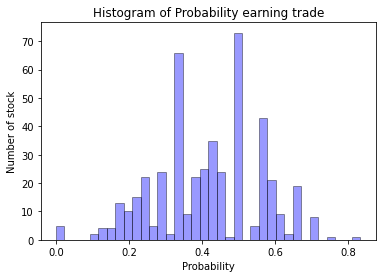

In [10]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# plot the probability of earning trade
# seaborn histogram
sns.distplot(result_data['win_chance'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Probability earning trade')
plt.ylabel('Number of stock')
plt.xlabel('Probability')

In [19]:
result_data['win_chance'].mean()

0.4171037768378196

2.5229203988613196


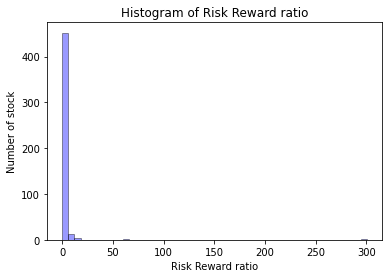

In [11]:
# plot the risk reward ratio
# seaborn histogram
sns.distplot(result_data['Risk Reward ratio'], hist=True, kde=False, 
             bins=int(250/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Risk Reward ratio')
plt.ylabel('Number of stock')
plt.xlabel('Risk Reward ratio')
print(result_data['Risk Reward ratio'].mean())

2.5229203988613196


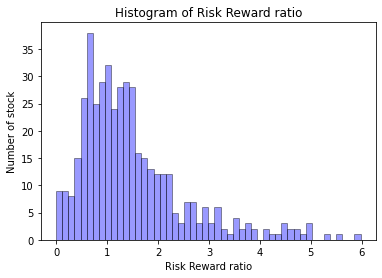

In [22]:
# plot the risk reward ratio
# seaborn histogram
sns.distplot(result_data[result_data['Risk Reward ratio']<6]['Risk Reward ratio'], hist=True, kde=False, 
             bins=int(250/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Risk Reward ratio')
plt.ylabel('Number of stock')
plt.xlabel('Risk Reward ratio')
print(result_data['Risk Reward ratio'].mean())

2.5229203988613196


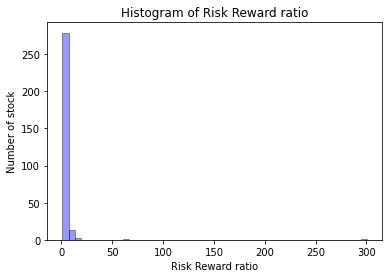

In [16]:
# plot the risk reward ratio
# seaborn histogram
sns.distplot(result_data[result_data['Risk Reward ratio']>1]['Risk Reward ratio'], hist=True, kde=False, 
             bins=int(250/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Risk Reward ratio')
plt.ylabel('Number of stock')
plt.xlabel('Risk Reward ratio')
print(result_data['Risk Reward ratio'].mean())